# Deep Reinforcement Learning Laboratory

In this laboratory session we will work on getting more advanced versions of Deep Reinforcement Learning algorithms up and running. Deep Reinforcement Learning is **hard**, and getting agents to stably train can be frustrating and requires quite a bit of subtlety in analysis of intermediate results. We will start by refactoring (a bit) my implementation of `REINFORCE` on the [Cartpole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/). 

## Exercise 1: Improving my `REINFORCE` Implementation (warm up)

In this exercise we will refactor a bit and improve some aspects of my `REINFORCE` implementation. 

**First Things First**: Spend some time playing with the environment to make sure you understand how it works.

In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import numpy as np
import pygame

# Instantiate a rendering and a non-rendering environment.
env_render = gym.make('CartPole-v1', render_mode='human')
env = gym.make('CartPole-v1')

<frozen importlib._bootstrap>:488: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


In [2]:
# Your code here. Call .reset() on the environment and inspect the output. Also, check out the observation_space.

# Given an environment, observation, and policy, sample from pi(a | obs). Returns the
# selected action and the log probability of that action (needed for policy gradient).
def select_action(env, obs, policy):
    dist = Categorical(policy(obs))
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return (action.item(), log_prob.reshape(1))

# Utility to compute the discounted total reward. Torch doesn't like flipped arrays, so we need to
# .copy() the final numpy array. There's probably a better way to do this.
def compute_returns(rewards, gamma):
    return np.flip(np.cumsum([gamma**(i+1)*r for (i, r) in enumerate(rewards)][::-1]), 0).copy()

# Given an environment and a policy, run it up to the maximum number of steps.
def run_episode(env, policy, maxlen=500):
    # Collect just about everything.
    observations = []
    actions = []
    log_probs = []
    rewards = []
    
    # Reset the environment and start the episode.
    (obs, info) = env.reset()
    for i in range(maxlen):
        # Get the current observation, run the policy and select an action.
        obs = torch.tensor(obs)
        (action, log_prob) = select_action(env, obs, policy)
        observations.append(obs)
        actions.append(action)
        log_probs.append(log_prob)
        
        # Advance the episode by executing the selected action.
        (obs, reward, term, trunc, info) = env.step(action)
        rewards.append(reward)
        if term or trunc:
            break
    return (observations, actions, torch.cat(log_probs), rewards)

In [3]:
# A simple, but generic, policy network with one hidden layer.
class PolicyNet(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], 128)
        self.fc2 = nn.Linear(128, env.action_space.n)
        
    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = F.softmax(self.fc2(s), dim=-1)
        return s

In [4]:
# A direct, inefficient, and probably buggy of the REINFORCE policy gradient algorithm.
def reinforce(policy, env, env_render=None, gamma=0.99, num_episodes=10):
    # The only non-vanilla part: we use Adam instead of SGD.
    opt = torch.optim.Adam(policy.parameters(), lr=1e-2)

    # Track episode rewards in a list.
    running_rewards = [0.0]
    
    # The main training loop.
    policy.train()
    for episode in range(num_episodes):
        # Run an episode of the environment, collect everything needed for policy update.
        (observations, actions, log_probs, rewards) = run_episode(env, policy)
        
        # Compute the discounted reward for every step of the episode. 
        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)
        
        # Keep a running average of total discounted rewards for the whole episode.
        running_rewards.append(0.05 * returns[0].item() + 0.95 * running_rewards[-1])
        
        # Standardize returns.
        returns = (returns - returns.mean()) / returns.std()
        
        # Make an optimization step
        opt.zero_grad()
        loss = (-log_probs * returns).mean()
        loss.backward()
        opt.step()
        
        # Render an episode after every 100 policy updates.
        if not episode % 100:
            if env_render:
                policy.eval()
                run_episode(env_render, policy)
                policy.train()
            print(f'Running reward: {running_rewards[-1]}')
    
    # Return the running rewards.
    policy.eval()
    return running_rewards

In [5]:
# Creo l'ambiente CartPole-v1
env = gym.make('CartPole-v1')

observation, info = env.reset()

# Stampiamo l'osservazione e info extra
print(observation)
print(info) 

# Spazio delle azioni e osservazioni per l'agente
print(f"Spazio delle azioni: {env.action_space}")
print(f"Spazio delle osservazioni: {env.observation_space}")

env.close()

[ 0.00625426 -0.00607073  0.01279898 -0.04804974]
{}
Spazio delle azioni: Discrete(2)
Spazio delle osservazioni: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


- Due possibili azioni sono permesse: 
  - Spingere il carrello a *sinistra*
  - Spingere il carrello a *destra*
- Quattro possibili osservazioni (ognuna definita su un intervallo di valori):
  - Posizione
  - Velocità
  - Angolo del polo
  - Velocità angolare del polo
  

**Next Things Next**: Now get your `REINFORCE` implementation working on the environment. You can import my (probably buggy and definitely inefficient) implementation here. Or even better, refactor an implementation into a separate package from which you can `import` the stuff you need here. 

Running reward: 0.6062709331512451
Running reward: 72.6409170162712
Running reward: 80.4393754214653
Running reward: 87.42150744951329
Running reward: 48.64328319495423


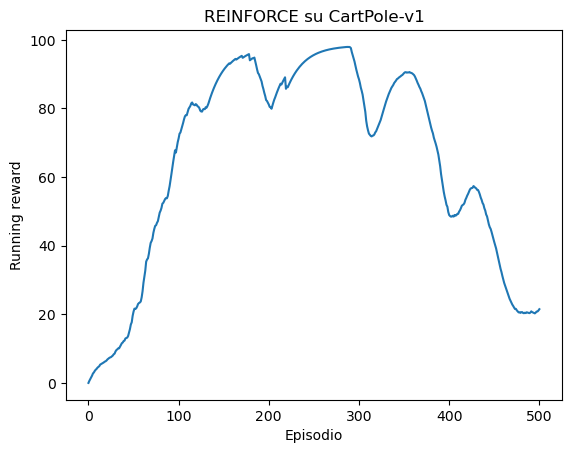

In [6]:
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_ 
# seed per la riproducibilità
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)

# Creo l'ambiente
env = gym.make('CartPole-v1')
env.reset(seed=seed)

# Definisco la policy
policy = PolicyNet(env)

# Addestro l'agente usando REINFORCE
rewards = reinforce(policy, env, env_render=None, num_episodes=500)

# Plot dei reward in funzione degli episodi
plt.plot(rewards)
plt.xlabel('Episodio')
plt.ylabel('Running reward')
plt.title('REINFORCE su CartPole-v1')
plt.show()

env.close()

**Last Things Last**: My implementation does a **super crappy** job of evaluating the agent performance during training. The running average is not a very good metric. Modify my implementation so that every $N$ iterations (make $N$ an argument to the training function) the agent is run for $M$ episodes in the environment. Collect and return: (1) The average **total** reward received over the $M$ iterations; and (2) the average episode length. Analyze the performance of your agents with these new metrics.

In [ ]:
def reinforce_with_eval(policy, env, render_mode=None, gamma=0.99, num_episodes=1000, N=50, M=10):

    opt = torch.optim.Adam(policy.parameters(), lr=1e-2)

    eval_avg_rewards = []
    eval_avg_lengths = []
    running_rewards = [0.0]

    policy.train()
    for episode in range(num_episodes):
        (observations, actions, log_probs, rewards) = run_episode(env, policy)

        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)
        running_rewards.append(0.05 * returns[0].item() + 0.95 * running_rewards[-1])

        if returns.std() > 1e-6:
            returns = (returns - returns.mean()) / returns.std()

        opt.zero_grad()
        loss = (-log_probs * returns).mean()
        loss.backward()
        opt.step()

        if (episode + 1) % N == 0:
            policy.eval()
            total_rewards = []
            total_lengths = []
            for _ in range(M):
                (obs, info) = env.reset()
                done = False
                total_reward = 0
                length = 0
                while not done:
                    obs = torch.tensor(obs)
                    action = select_action(env, obs, policy)[0]
                    (obs, reward, term, trunc, info) = env.step(action)
                    total_reward += reward
                    done = term or trunc
                    length += 1 
                total_rewards.append(total_reward)
                total_lengths.append(length)
             
            avg_reward_on_eval = np.mean(total_rewards) # Rappresenta il reward medio su M episodi di valutazione
            avg_length_on_eval = np.mean(total_lengths)
            eval_avg_rewards.append(avg_reward_on_eval)
            eval_avg_lengths.append(avg_length_on_eval)
            print(f'Episodio {episode + 1}, Reward medio: {avg_reward_on_eval}, Lunghezza media: {avg_length_on_eval}')
            policy.train()

    return running_rewards, eval_avg_rewards, eval_avg_lengths

Episodio 50, Reward medio: 117.5, Lunghezza media: 117.5
Episodio 100, Reward medio: 114.15, Lunghezza media: 114.15
Episodio 150, Reward medio: 324.3, Lunghezza media: 324.3
Episodio 200, Reward medio: 383.85, Lunghezza media: 383.85
Episodio 250, Reward medio: 467.1, Lunghezza media: 467.1
Episodio 300, Reward medio: 500.0, Lunghezza media: 500.0
Episodio 350, Reward medio: 405.8, Lunghezza media: 405.8
Episodio 400, Reward medio: 500.0, Lunghezza media: 500.0
Episodio 450, Reward medio: 500.0, Lunghezza media: 500.0
Episodio 500, Reward medio: 500.0, Lunghezza media: 500.0


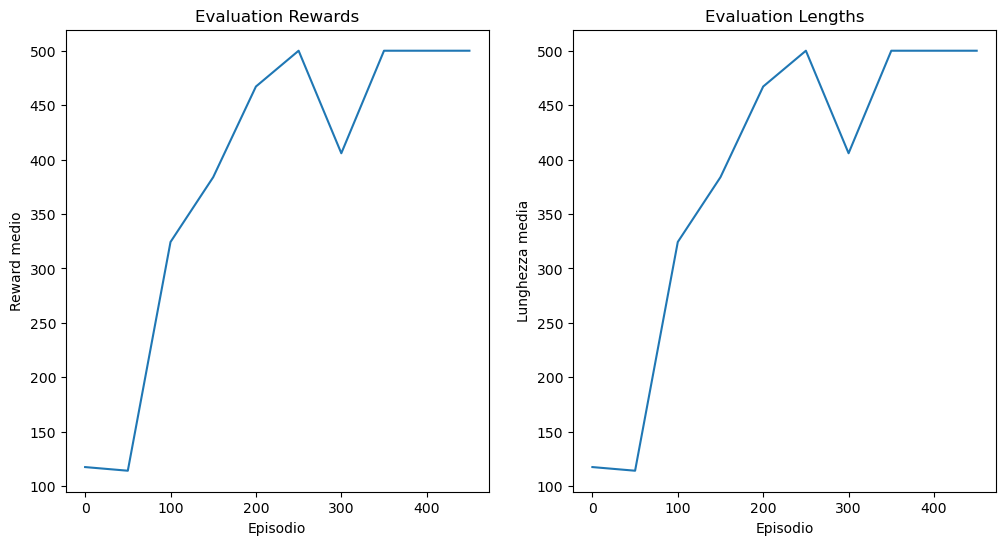

In [8]:
# Addestra l'agente usando REINFORCE
# Ogni N episodi, esegue M episodi di valutazione
train_rewards, eval_rewards, eval_lengths = reinforce_with_eval(policy, env, render_mode=None, num_episodes=500, N=50, M=20)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(np.arange(len(eval_rewards))* 50, eval_rewards, label='Train Rewards')
plt.xlabel('Episodio')
plt.ylabel('Reward medio')
plt.title('Evaluation Rewards')

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(eval_lengths))*50, eval_lengths, label='Eval Rewards')
plt.xlabel('Episodio')
plt.ylabel('Lunghezza media')
plt.title('Evaluation Lengths')

plt.show()



In [10]:
torch.save(policy.state_dict(), 'policy_cartpole.pt')

In [11]:
env_r = gym.make('CartPole-v1', render_mode='human') 
policy.eval()
# Singolo episodio per valutare la policy
run_episode(env_r, policy)
env_r.close()

-----
## Exercise 2: `REINFORCE` with a Value Baseline (warm up)

In this exercise we will augment my implementation (or your own) of `REINFORCE` to subtract a baseline from the target in the update equation in order to stabilize (and hopefully speed-up) convergence. For now we will stick to the Cartpole environment.



In [ ]:
# Rete neurale per la baseline

class ValueNet(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = self.fc2(s) 
        return s # Restituisce la stima del valore V(s) per uno stato s

**First Things First**: Recall from the slides on Deep Reinforcement Learning that we can **subtract** any function that doesn't depend on the current action from the q-value without changing the (maximum of our) objecttive function $J$:  

$$ \nabla J(\boldsymbol{\theta}) \propto \sum_{s} \mu(s) \sum_a \left( q_{\pi}(s, a) - b(s) \right) \nabla \pi(a \mid s, \boldsymbol{\theta}) $$

In `REINFORCE` this means we can subtract from our target $G_t$:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - b(S_t)) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

Since we are only interested in the **maximum** of our objective, we can also **rescale** our target by any function that also doesn't depend on the action. A **simple baseline** which is even independent of the state -- that is, it is **constant** for each episode -- is to just **standardize rewards within the episode**. So, we **subtract** the average return and **divide** by the variance of returns:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha \left(\frac{G_t - \bar{G}}{\sigma_G}\right) \nabla  \pi(A_t \mid s, \boldsymbol{\theta}) $$

This baseline is **already** implemented in my implementation of `REINFORCE`. Experiment with and without this standardization baseline and compare the performance. We are going to do something more interesting.

In [13]:
def reinforce_with_standardization(policy, env, render_mode=None, gamma=0.99, num_episodes=1000, N=50, M=10, standardize=True):

    opt = torch.optim.Adam(policy.parameters(), lr=1e-2)

    eval_avg_rewards = []
    eval_avg_lengths = []
    running_rewards = [0.0]

    policy.train()
    for episode in range(num_episodes):
        (observations, actions, log_probs, rewards) = run_episode(env, policy)

        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)
        running_rewards.append(0.05 * returns[0].item() + 0.95 * running_rewards[-1])

        if standardize and returns.std() > 1e-6:
            returns = (returns - returns.mean()) / returns.std()

        opt.zero_grad()
        loss = (-log_probs * returns).mean()
        loss.backward()
        opt.step()

        if (episode + 1) % N == 0:
            policy.eval()
            total_rewards = []
            total_lengths = []
            for _ in range(M):
                (obs, info) = env.reset()
                done = False
                total_reward = 0
                length = 0
                while not done:
                    obs = torch.tensor(obs)
                    action = select_action(env, obs, policy)[0]
                    (obs, reward, term, trunc, info) = env.step(action)
                    total_reward += reward
                    done = term or trunc
                    length += 1 
                total_rewards.append(total_reward)
                total_lengths.append(length)
            
            avg_reward_on_eval = np.mean(total_rewards)
            avg_length_on_eval = np.mean(total_lengths)
            eval_avg_rewards.append(avg_reward_on_eval)
            eval_avg_lengths.append(avg_length_on_eval)
            print(f'Episodio {episode + 1}, Reward medio: {avg_reward_on_eval}, Lunghezza media: {avg_length_on_eval}')
            policy.train()

    return running_rewards, eval_avg_rewards, eval_avg_lengths

In [14]:
# Addestra l'agente usando REINFORCE con standardizzazione
policy_with_standardization = PolicyNet(env)

_, eval_rewards_standardized, _ = reinforce_with_standardization(policy_with_standardization, env, render_mode=None, num_episodes=500, N=50, M=20, standardize=True)

Episodio 50, Reward medio: 159.05, Lunghezza media: 159.05
Episodio 100, Reward medio: 429.65, Lunghezza media: 429.65
Episodio 150, Reward medio: 117.4, Lunghezza media: 117.4
Episodio 200, Reward medio: 117.1, Lunghezza media: 117.1
Episodio 250, Reward medio: 187.95, Lunghezza media: 187.95
Episodio 300, Reward medio: 326.15, Lunghezza media: 326.15
Episodio 350, Reward medio: 159.75, Lunghezza media: 159.75
Episodio 400, Reward medio: 500.0, Lunghezza media: 500.0
Episodio 450, Reward medio: 500.0, Lunghezza media: 500.0
Episodio 500, Reward medio: 500.0, Lunghezza media: 500.0


In [16]:
# Addestra l'agente senza standardizzazione
policy_no_standardization = PolicyNet(env)
_, eval_rewards_no_standardization, _ = reinforce_with_standardization(policy_no_standardization, env, render_mode=None, num_episodes=500, N=50, M=20, standardize=False)


Episodio 50, Reward medio: 67.65, Lunghezza media: 67.65
Episodio 100, Reward medio: 72.2, Lunghezza media: 72.2
Episodio 150, Reward medio: 116.65, Lunghezza media: 116.65
Episodio 200, Reward medio: 110.55, Lunghezza media: 110.55
Episodio 250, Reward medio: 60.8, Lunghezza media: 60.8
Episodio 300, Reward medio: 89.75, Lunghezza media: 89.75
Episodio 350, Reward medio: 66.7, Lunghezza media: 66.7
Episodio 400, Reward medio: 70.35, Lunghezza media: 70.35
Episodio 450, Reward medio: 104.3, Lunghezza media: 104.3
Episodio 500, Reward medio: 114.15, Lunghezza media: 114.15


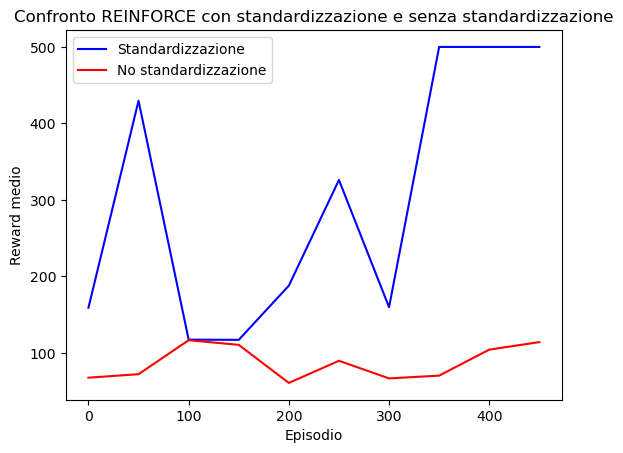

In [17]:
# Confronto delle performance tra REINFORCE con standardizzazione e senza standardizzazione
plt.plot(np.arange(len(eval_rewards_standardized)) * 50, eval_rewards_standardized, label='Standardizzazione', color='blue')
plt.plot(np.arange(len(eval_rewards_no_standardization)) * 50, eval_rewards_no_standardization, label='No standardizzazione', color='red')
plt.xlabel('Episodio')
plt.ylabel('Reward medio')
plt.title('Confronto REINFORCE con standardizzazione e senza standardizzazione')
plt.legend()
plt.show()

- **Questo grafico mostra l'importanza della standardizzazione dei ritorni per ridurre la varianza del gradiente e migliorare la stabilità dell'apprendimento**

**The Real Exercise**: Standard practice is to use the state-value function $v(s)$ as a baseline. This is intuitively appealing -- we are more interested in updating out policy for returns that estimate the current **value** worse. Our new update becomes:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - \tilde{v}(S_t \mid \mathbf{w})) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

where $\tilde{v}(s \mid \mathbf{w})$ is a **deep neural network** with parameters $w$ that estimates $v_\pi(s)$. What neural network? Typically, we use the **same** network architecture as that of the Policy.

**Your Task**: Modify your implementation to fit a second, baseline network to estimate the value function and use it as **baseline**. 

In [18]:
def reinforce_with_baseline(policy, value_net, env, render_mode=None, gamma=0.99, num_episodes=1000, N=50, M=10):

    opt_policy = torch.optim.Adam(policy.parameters(), lr=1e-2)
    opt_value = torch.optim.Adam(value_net.parameters(), lr=1e-2)

    eval_avg_rewards = []
    eval_avg_lengths = []
    running_rewards = [0.0]

    policy.train()
    value_net.train()

    for episode in range(num_episodes):
        (observations, actions, log_probs, rewards) = run_episode(env, policy)
        
        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)
        running_rewards.append(0.05 * returns[0].item() + 0.95 * running_rewards[-1])

        obs_tensor = torch.stack(observations)
        
        # Forward pass per la value_net
        values = value_net(obs_tensor).squeeze()
        advantages = returns - values.detach()

        # Forward pass per la policy_net
        action_probs = policy(obs_tensor)
        entropy = -(action_probs * (action_probs + 1e-8).log()).sum(dim=1).mean()

        # Loss per policy_net e value_net
        loss_policy = (-log_probs * advantages).mean() - 0.01 * entropy
        loss_value = F.mse_loss(values, returns)

        # Step di ottimizzazione
        opt_policy.zero_grad()
        loss_policy.backward()
        opt_policy.step()

        opt_value.zero_grad()
        loss_value.backward()
        opt_value.step()

        # Valutazione ogni N episodi
        if (episode + 1) % N == 0:
            policy.eval()
            total_rewards = []
            total_lengths = []    
            for _ in range(M):
                obs, _ = env.reset()
                done = False 
                length = 0
                total_reward = 0

                while not done:
                    obs_tensor = torch.tensor(obs, dtype=torch.float32)
                    action, _ = select_action(env, obs_tensor, policy)
                    (obs, reward, term, trunc, _) = env.step(action)
                    total_reward += reward
                    done = term or trunc
                    length += 1
                total_rewards.append(total_reward)
                total_lengths.append(length)
            avg_reward_on_eval = np.mean(total_rewards) 
            avg_length_on_eval = np.mean(total_lengths)
            eval_avg_rewards.append(avg_reward_on_eval)
            eval_avg_lengths.append(avg_length_on_eval)
            print(f'Episodio {episode + 1}, Reward medio: {avg_reward_on_eval}, Lunghezza media: {avg_length_on_eval}')
            policy.train()

    return running_rewards, eval_avg_rewards, eval_avg_lengths      

Episodio 50, Reward medio: 59.05, Lunghezza media: 59.05
Episodio 100, Reward medio: 445.35, Lunghezza media: 445.35
Episodio 150, Reward medio: 72.05, Lunghezza media: 72.05
Episodio 200, Reward medio: 356.5, Lunghezza media: 356.5
Episodio 250, Reward medio: 480.9, Lunghezza media: 480.9
Episodio 300, Reward medio: 478.95, Lunghezza media: 478.95
Episodio 350, Reward medio: 480.3, Lunghezza media: 480.3
Episodio 400, Reward medio: 500.0, Lunghezza media: 500.0
Episodio 450, Reward medio: 500.0, Lunghezza media: 500.0
Episodio 500, Reward medio: 500.0, Lunghezza media: 500.0


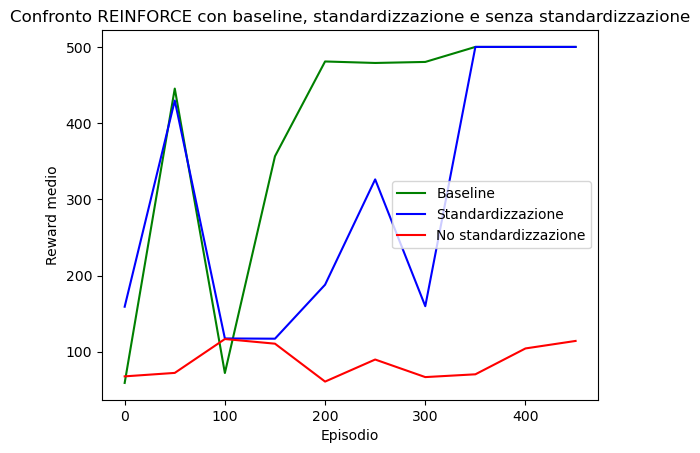

In [20]:
# Creo la policy_net e la value_net
policy = PolicyNet(env)
value_net = ValueNet(env)

# Addestra l'agente usando REINFORCE con baseline: state-value function
_, eval_rewards_baseline, _ = reinforce_with_baseline(policy, value_net, env, render_mode=None, num_episodes=500, N=50, M=20)

plt.plot(np.arange(len(eval_rewards_baseline)) * 50, eval_rewards_baseline, label='Baseline', color='green')
plt.plot(np.arange(len(eval_rewards_standardized)) * 50, eval_rewards_standardized, label='Standardizzazione', color='blue')
plt.plot(np.arange(len(eval_rewards_no_standardization)) * 50, eval_rewards_no_standardization, label='No standardizzazione', color='red')
plt.xlabel('Episodio')
plt.ylabel('Reward medio')
plt.title('Confronto REINFORCE con baseline, standardizzazione e senza standardizzazione')
plt.legend()
plt.show()

### Conclusioni
Ho confrontato tre versioni dell'algoritmo *REINFORCE*:
- Baseline neurale (ValueNet)
- Baseline standardizzazione: attraverso la standardizzazione dei ritorni su ogni episodio 
- No standardizzazione

**Osservazione**:
- L’introduzione di una baseline stimata tramite rete neurale riduce la varianza del gradiente, favorendo una convergenza più stabile e veloce, con performance elevate già nei primi episodi.

-----
## Exercise 3: Going Deeper

As usual, pick **AT LEAST ONE** of the following exercises to complete.

### Exercise 3.1: Solving Lunar Lander with `REINFORCE` (easy)

Use my (or even better, improve on my) implementation of `REINFORCE` to solve the [Lunar Lander Environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/). This environment is a little bit harder than Cartpole, but not much. Make sure you perform the same types of analyses we did during the lab session to quantify and qualify the performance of your agents.

### Exercise 3.2: Solving Cartpole and Lunar Lander with `Deep Q-Learning` (harder)

On policy Deep Reinforcement Learning tends to be **very unstable**. Write an implementation (or adapt an existing one) of `Deep Q-Learning` to solve our two environments (Cartpole and Lunar Lander). To do this you will need to implement a **Replay Buffer** and use a second, slow-moving **target Q-Network** to stabilize learning.

### Exercise 3.3: Solving the OpenAI CarRacing environment (hardest) 

Use `Deep Q-Learning` -- or even better, an off-the-shelf implementation of **Proximal Policy Optimization (PPO)** -- to train an agent to solve the [OpenAI CarRacing](https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN) environment. This will be the most *fun*, but also the most *difficult*. Some tips:

1. Make sure you use the `continuous=False` argument to the environment constructor. This ensures that the action space is **discrete** (we haven't seen how to work with continuous action spaces).
2. Your Q-Network will need to be a CNN. A simple one should do, with two convolutional + maxpool layers, folowed by a two dense layers. You will **definitely** want to use a GPU to train your agents.
3. The observation space of the environment is a single **color image** (a single frame of the game). Most implementations stack multiple frames (e.g. 3) after converting them to grayscale images as an observation.

 

In [21]:
import gymnasium as gym

# Esercizio 3.1
# Crea l'ambiente LunarLander-v2
env_lunar = gym.make("LunarLander-v2")

# Esplorazione dell'ambiente
(observation, info) = env_lunar.reset()
print(f'Osservazione iniziale: {observation}')
print(f'Info extra: {info}')

print(f'Spazio delle azioni: {env_lunar.action_space}')
print(f'Spazio delle osservazioni: {env_lunar.observation_space}')

env_lunar.close()

Osservazione iniziale: [ 0.00282154  1.4173985   0.28577012  0.28792623 -0.00326262 -0.06473111
  0.          0.        ]
Info extra: {}
Spazio delle azioni: Discrete(4)
Spazio delle osservazioni: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)


- LunarLander-v2 è un ambiente un pò più complesso del precedente.
**Azioni possibili**
- 0: Non fare nulla
- 1: attivare il motore di orientamento sinistro
- 2: attivare il motore principale
- 3: attivare il motore di orientamento destro

**Osservazioni**
Lo spazio delle osservazioni è dato da un box a 8 dimensioni.
- Coordinate x e y
- Velocità lineari in x e y
- Angolo
- Velocità angolare
- Due valori booleani che controllano se vi è del contatto con il suolo

In [24]:
# Addestro l'agente usando REINFORCE con le due baseline viste in precedenza
# In entrambi i casi si addestra per 1000 episodi

policy_lunar = PolicyNet(env_lunar)

_, eval_rewards_lunar, _ = reinforce_with_standardization(policy_lunar, env_lunar, render_mode=None, num_episodes=1000, N=50, M=20, standardize=True)


Episodio 50, Reward medio: -124.68948394985742, Lunghezza media: 82.7
Episodio 100, Reward medio: -83.91729793598522, Lunghezza media: 99.15
Episodio 150, Reward medio: -108.9545128053546, Lunghezza media: 81.15
Episodio 200, Reward medio: -189.7980326172955, Lunghezza media: 105.05
Episodio 250, Reward medio: -265.9227256335654, Lunghezza media: 143.9
Episodio 300, Reward medio: -133.83194406217436, Lunghezza media: 105.55
Episodio 350, Reward medio: -312.58537802706826, Lunghezza media: 158.55
Episodio 400, Reward medio: -746.9539954320628, Lunghezza media: 292.35
Episodio 450, Reward medio: -180.84577644800189, Lunghezza media: 234.8
Episodio 500, Reward medio: -13.527384753019424, Lunghezza media: 816.7
Episodio 550, Reward medio: -58.025831540244965, Lunghezza media: 226.3
Episodio 600, Reward medio: -98.55508882848531, Lunghezza media: 80.1
Episodio 650, Reward medio: -136.2094900634394, Lunghezza media: 77.25
Episodio 700, Reward medio: -77.80058998605804, Lunghezza media: 71.8


In [25]:
# Addestro l'agente usando REINFORCE con baseline neurale

policy_lunar_baseline = PolicyNet(env_lunar)
value_net_lunar = ValueNet(env_lunar)

_, eval_rewards_lunar_baseline, _ = reinforce_with_baseline(policy_lunar_baseline, value_net_lunar, env_lunar, render_mode=None, num_episodes=1000, N=50, M=20)

Episodio 50, Reward medio: -829.0918838326336, Lunghezza media: 139.4
Episodio 100, Reward medio: -184.73309958485737, Lunghezza media: 155.4
Episodio 150, Reward medio: -98.38512712474845, Lunghezza media: 90.55
Episodio 200, Reward medio: -73.51290517425737, Lunghezza media: 136.6
Episodio 250, Reward medio: -44.90757692984609, Lunghezza media: 98.65
Episodio 300, Reward medio: -53.571594984902255, Lunghezza media: 83.7
Episodio 350, Reward medio: -118.42381445950173, Lunghezza media: 743.9
Episodio 400, Reward medio: -87.86269411758016, Lunghezza media: 802.55
Episodio 450, Reward medio: 22.776116868849897, Lunghezza media: 598.45
Episodio 500, Reward medio: 7.209411130803536, Lunghezza media: 472.1
Episodio 550, Reward medio: -44.54942747832647, Lunghezza media: 412.85
Episodio 600, Reward medio: -8.09582263176038, Lunghezza media: 862.05
Episodio 650, Reward medio: -97.93340520165617, Lunghezza media: 938.95
Episodio 700, Reward medio: 30.263657877391744, Lunghezza media: 885.05
E

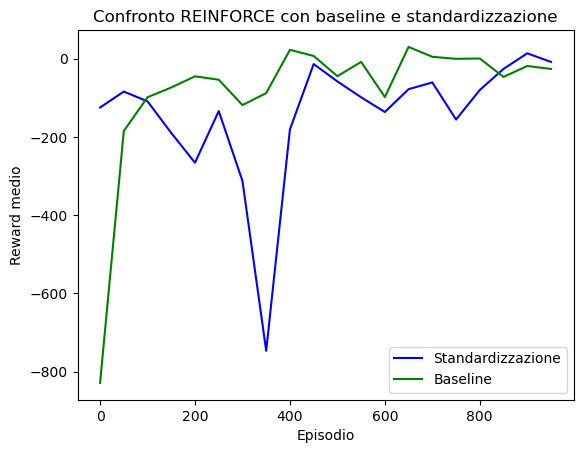

In [26]:
plt.plot(np.arange(len(eval_rewards_lunar)) * 50, eval_rewards_lunar, label='Standardizzazione', color='blue')
plt.plot(np.arange(len(eval_rewards_lunar_baseline)) * 50, eval_rewards_lunar_baseline, label='Baseline', color='green')
plt.xlabel('Episodio')
plt.ylabel('Reward medio')
plt.title('Confronto REINFORCE con baseline e standardizzazione')
plt.legend()
plt.show()

In [27]:
# Valutazione su un singolo episodio
env_lunar_r = gym.make("LunarLander-v2", render_mode='human')
policy_lunar_baseline.eval()
run_episode(env_lunar_r, policy_lunar_baseline)
env_lunar_r.close()

### Conclusioni
- Dall'ultimo grafico emerge che la baseline neurale ha portato ad avere una policy più stabile, però non risolve del tutto l'ambiente LunarLander.
- I reward medi durante gli episodi di valutazione si mantengono su valori leggermente negativi (talvolta positivi) a partire dall'episodio 200 circa.
- Le durate medie degli episodi di valutazione si allungano notevolmente rispetto al caso della standardizzazione.

Sono necessarie ulteriori modifiche per indirizzare l’agente verso comportamenti più efficaci e stabilire soluzioni più robuste e coerenti.  